In [1]:
import cv2
import numpy as np 
import mediapipe as mp 
import os 
import matplotlib.pyplot as plt 

In [2]:
mp_holistic = mp.solutions.holistic  # Holistic model
mp_drawing = mp.solutions.drawing_utils  # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False                   # image is no longer writeable
    results = model.process(image)                  # make prediction
    image.flags.writeable = True                    # image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results


def draw_landmarks(image, results):

    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)  # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)  # Draw pose connections 
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)  # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections


def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose,face,lh, rh])

In [33]:
(33*4)  + (21*3) + (21*3)

258

In [4]:
# Function to process video and extract keypoints
def process_video(video_path, sequence_length=30):  # 30 frames = 1 second at 30fps
    # Initialize MediaPipe Holistic model
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        # Read the video
        cap = cv2.VideoCapture(video_path)
        keypoints_sequence = []
        frame_count = 0
        
        while cap.isOpened() and frame_count < sequence_length:
            ret, frame = cap.read()
            if not ret:
                break
                
            # Make detections
            image, results = mediapipe_detection(frame, holistic)
            
            # Extract keypoints
            keypoints = extract_keypoints(results)
            keypoints_sequence.append(keypoints)
            frame_count += 1
            
            # Optional: Draw landmarks for visualization
            # draw_landmarks(image, results)
            
            # Optional: Display the frame
            # cv2.imshow('Video Processing', image)
            
            # Break the loop if 'q' is pressed
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
                
        cap.release()
        cv2.destroyAllWindows()
        
        # If we didn't get enough frames, pad with zeros
        while len(keypoints_sequence) < sequence_length:
            keypoints_sequence.append(np.zeros_like(keypoints_sequence[0]))
            
    return np.array(keypoints_sequence)

In [15]:
# Example usage
# Replace 'path_to_your_video.mp4' with your video file path
video_path = 'path_to_your_video.mp4'
keypoints_sequence = process_video(video_path)

# The keypoints_sequence will be a numpy array with shape (num_frames, 1662)
# Where 1662 comes from:
# - 33 pose landmarks × 4 values (x, y, z, visibility) = 132
# - 468 face landmarks × 3 values (x, y, z) = 1404
# - 21 landmarks × 3 values (x, y, z) for each hand = 63 × 2 = 126
print(f"Extracted keypoints shape: {keypoints_sequence.shape}")


KeyboardInterrupt



In [7]:
# Process videos from all folders
DATA_PATH = os.path.join('data')
actions = os.listdir(DATA_PATH)
# Remove any non-directory items or hidden folders
actions = [action for action in actions if os.path.isdir(os.path.join(DATA_PATH, action)) and not action.startswith('.')]

# Dictionary to store sequences for each action
action_sequences = {}

# Number of frames to extract from each video
SEQUENCE_LENGTH = 30  # 30 frames = 1 second at 30fps

# Process each action folder
for action in actions:
    action_sequences[action] = []
    action_dir = os.path.join(DATA_PATH, action)
    
    # Get all video files in the action directory
    videos = [f for f in os.listdir(action_dir) if f.endswith('.MOV')]
    
    print(f"Processing videos for action: {action}")
    for video in videos:
        video_path = os.path.join(action_dir, video)
        # Process the video and get keypoints
        sequence = process_video(video_path, sequence_length=SEQUENCE_LENGTH)
        action_sequences[action].append(sequence)
        print(f"Processed {video} - Sequence shape: {sequence.shape}")

# Print summary
for action, sequences in action_sequences.items():
    if sequences:
        print(f"\nAction: {action}")
        print(f"Number of videos processed: {len(sequences)}")
        print(f"Sequence shapes: {[seq.shape for seq in sequences]}")

Processing videos for action: alive
Processed MVI_9703.MOV - Sequence shape: (30, 1662)
Processed MVI_9704.MOV - Sequence shape: (30, 1662)
Processed MVI_9705.MOV - Sequence shape: (30, 1662)
Processed MVI_9706.MOV - Sequence shape: (30, 1662)
Processed MVI_9827.MOV - Sequence shape: (30, 1662)
Processed MVI_9828.MOV - Sequence shape: (30, 1662)
Processed MVI_9829.MOV - Sequence shape: (30, 1662)
Processed MVI_9830.MOV - Sequence shape: (30, 1662)
Processing videos for action: bad
Processed MVI_5161.MOV - Sequence shape: (30, 1662)
Processed MVI_5162.MOV - Sequence shape: (30, 1662)
Processed MVI_5163.MOV - Sequence shape: (30, 1662)
Processed MVI_5241.MOV - Sequence shape: (30, 1662)
Processed MVI_5242.MOV - Sequence shape: (30, 1662)
Processed MVI_5243.MOV - Sequence shape: (30, 1662)
Processed MVI_5319.MOV - Sequence shape: (30, 1662)
Processed MVI_5320.MOV - Sequence shape: (30, 1662)
Processed MVI_5321.MOV - Sequence shape: (30, 1662)
Processed MVI_9271.MOV - Sequence shape: (30, 

In [6]:
DATA_PATH = os.path.join('data')
print(DATA_PATH)
actions = os.listdir(DATA_PATH)
print(len(actions))


data
59


In [14]:
len(action_sequences['wide'])

21

In [15]:
# Create directories to save the processed data
DATA_PATH = 'processed_2_data'
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

# Prepare data for saving
X = []  # Input features (keypoints)
y = []  # Labels
# Create a mapping of action names to numerical labels
action_to_label = {action: idx for idx, action in enumerate(actions)}

# Convert sequences to the right format and create labels
for action, sequences in action_sequences.items():
    for sequence in sequences:
        X.append(sequence)
        y.append(action_to_label[action])

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Save the processed data
np.save(os.path.join(DATA_PATH, 'X.npy'), X)
np.save(os.path.join(DATA_PATH, 'y.npy'), y)

# Save the label mapping for future reference
import json
with open(os.path.join(DATA_PATH, 'action_labels.json'), 'w') as f:
    json.dump(action_to_label, f)

print(f"Saved data shape - X: {X.shape}, y: {y.shape}")
print(f"\nData saved in {DATA_PATH}:")
print(f"- X.npy: contains all sequences of keypoints")
print(f"- y.npy: contains corresponding labels")
print(f"- action_labels.json: mapping between actions and numerical labels")

# Print the label mapping
print("\nAction to label mapping:")
for action, label in action_to_label.items():
    print(f"{action}: {label}")

Saved data shape - X: (788, 30, 1662), y: (788,)

Data saved in processed_data:
- X.npy: contains all sequences of keypoints
- y.npy: contains corresponding labels
- action_labels.json: mapping between actions and numerical labels

Action to label mapping:
alive: 0
bad: 1
Beautiful: 2
big large: 3
Blind: 4
cheap: 5
clean: 6
cold: 7
cool: 8
curved: 9
dead: 10
Deaf: 11
deep: 12
dirty: 13
dry: 14
expensive: 15
famous: 16
fast: 17
female: 18
flat: 19
good: 20
happy: 21
hard: 22
healthy: 23
heavy: 24
high: 25
hot: 26
light: 27
long: 28
loose: 29
loud: 30
low: 31
male: 32
Mean: 33
narrow: 34
new: 35
Nice: 36
old: 37
poor: 38
quiet: 39
rich: 40
sad: 41
shallow: 42
short: 43
sick: 44
slow: 45
small little: 46
soft: 47
strong: 48
tall: 49
thick: 50
thin: 51
tight: 52
Ugly: 53
warm: 54
weak: 55
wet: 56
wide: 57
young: 58


In [2]:
import json
# Example of how to load the saved data for training
def load_data(data_path='processed_3_data_normalized'):
    # Load the keypoints and labels
    X = np.load(os.path.join(data_path, 'X.npy'))
    y = np.load(os.path.join(data_path, 'y.npy'))
    
    # Load the label mapping
    with open(os.path.join(data_path, 'action_labels.json'), 'r') as f:
        action_to_label = json.load(f)
    
    # Create reverse mapping (numerical label to action name)
    label_to_action = {int(v): k for k, v in action_to_label.items()}
    
    return X, y, action_to_label, label_to_action

# Load the data
X, y, action_to_label, label_to_action = load_data()
print(f"Loaded data shape - X: {X.shape}, y: {y.shape}")
print(f"\nNumber of sequences for each action:")
for label in np.unique(y):
    action = label_to_action[label]  # Now using integer label directly
    count = np.sum(y == label)
    print(f"{action}: {count} sequences")

Loaded data shape - X: (1332, 30, 258), y: (1332,)

Number of sequences for each action:
alive: 24 sequences
bad: 21 sequences
Beautiful: 24 sequences
big large: 21 sequences
Blind: 24 sequences
cheap: 24 sequences
clean: 24 sequences
cold: 20 sequences
cool: 21 sequences
curved: 24 sequences
dead: 24 sequences
Deaf: 24 sequences
deep: 24 sequences
dirty: 24 sequences
dry: 21 sequences
expensive: 24 sequences
famous: 24 sequences
fast: 21 sequences
female: 24 sequences
flat: 24 sequences
good: 21 sequences
happy: 21 sequences
hard: 24 sequences
healthy: 21 sequences
heavy: 24 sequences
high: 24 sequences
hot: 21 sequences
light: 24 sequences
long: 21 sequences
loose: 24 sequences
loud: 21 sequences
low: 24 sequences
male: 24 sequences
Mean: 24 sequences
narrow: 21 sequences
new: 21 sequences
Nice: 20 sequences
old: 21 sequences
poor: 24 sequences
quiet: 21 sequences
rich: 24 sequences
sad: 24 sequences
shallow: 24 sequences
short: 21 sequences
sick: 21 sequences
slow: 21 sequences
smal

In [8]:
print(X.shape)
print(y.shape)
X.max()

(1332, 30, 258)
(1332,)


1.4460318982601166

In [29]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout, Bidirectional,GRU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers, initializers

In [4]:
labels = y.copy()  # integer labels (0..num_classes-1)
num_classes = len(np.unique(labels))
y = to_categorical(labels, num_classes=num_classes).astype(int)
print('num_classes =', num_classes, 'labels shape =', labels.shape, 'y(one-hot) shape =', y.shape)

num_classes = 59 labels shape = (1332,) y(one-hot) shape = (1332, 59)


In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train,x_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=21)

In [21]:
# from tensorflow.keras.optimizers import Adam
# model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [53]:
model = Sequential([
    GRU(128, return_sequences=True, activation='relu',input_shape=(30, 258)),
    BatchNormalization(),
    Dropout(0.25),

    GRU(64, return_sequences=True, kernel_initializer=initializers.HeNormal(),activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    GRU(64, return_sequences=False, kernel_initializer=initializers.HeNormal(),activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(256, kernel_initializer=initializers.HeNormal(),activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, kernel_initializer=initializers.HeNormal(), activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])

# Compile the model
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Build the model to enable summary
model.build(input_shape=(None, 30, 258))
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_34 (GRU)                (None, 30, 128)           148992    
                                                                 
 batch_normalization_63 (Bat  (None, 30, 128)          512       
 chNormalization)                                                
                                                                 
 dropout_62 (Dropout)        (None, 30, 128)           0         
                                                                 
 gru_35 (GRU)                (None, 30, 64)            37248     
                                                                 
 batch_normalization_64 (Bat  (None, 30, 64)           256       
 chNormalization)                                                
                                                                 
 dropout_63 (Dropout)        (None, 30, 64)          

In [8]:
# Set up TensorBoard callback for monitoring training
import datetime
log_dir = 'logs/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [21]:
# Ensure labels are integers and compute unique classes
labels_int = labels.astype(int)
unique_classes = np.array(sorted(np.unique(labels_int)))  # Convert to numpy.ndarray
print("Unique classes in dataset:", unique_classes)

Unique classes in dataset: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58]


In [ ]:
# from sklearn.utils import compute_class_weight
# # Compute class weights using the integer labels
# class_weights_array = compute_class_weight(
#     class_weight='balanced',
#     classes=unique_classes,
#     y=labels_int
# )

# # Create class weight dictionary with integer keys
# class_weight = {int(class_idx): weight for class_idx, weight in zip(unique_classes, class_weights_array)}
# print('Class weight mapping:', class_weight)

Class weight mapping: {0: 0.940677966101695, 1: 1.0750605326876512, 2: 0.940677966101695, 3: 1.0750605326876512, 4: 0.940677966101695, 5: 0.940677966101695, 6: 0.940677966101695, 7: 1.1288135593220339, 8: 1.0750605326876512, 9: 0.940677966101695, 10: 0.940677966101695, 11: 0.940677966101695, 12: 0.940677966101695, 13: 0.940677966101695, 14: 1.0750605326876512, 15: 0.940677966101695, 16: 0.940677966101695, 17: 1.0750605326876512, 18: 0.940677966101695, 19: 0.940677966101695, 20: 1.0750605326876512, 21: 1.0750605326876512, 22: 0.940677966101695, 23: 1.0750605326876512, 24: 0.940677966101695, 25: 0.940677966101695, 26: 1.0750605326876512, 27: 0.940677966101695, 28: 1.0750605326876512, 29: 0.940677966101695, 30: 1.0750605326876512, 31: 0.940677966101695, 32: 0.940677966101695, 33: 0.940677966101695, 34: 1.0750605326876512, 35: 1.0750605326876512, 36: 1.1288135593220339, 37: 1.0750605326876512, 38: 0.940677966101695, 39: 1.0750605326876512, 40: 0.940677966101695, 41: 0.940677966101695, 42: 

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [54]:
# Callbacks
early = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Training hyperparameters
epochs = 500
batch_size = 8

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[tensorboard_callback, early, reduce_lr],
    shuffle=True
)

Epoch 1/500
27/27 [==============================] - 13s 123ms/step - loss: 4.7598 - categorical_accuracy: 0.0235 - val_loss: 4.0802 - val_categorical_accuracy: 0.0094 - lr: 0.0010
Epoch 2/500
27/27 [==============================] - 2s 81ms/step - loss: 4.3772 - categorical_accuracy: 0.0364 - val_loss: 4.0577 - val_categorical_accuracy: 0.0047 - lr: 0.0010
Epoch 3/500
27/27 [==============================] - 2s 84ms/step - loss: 4.0606 - categorical_accuracy: 0.0622 - val_loss: 4.0689 - val_categorical_accuracy: 0.0094 - lr: 0.0010
Epoch 4/500
27/27 [==============================] - 2s 83ms/step - loss: 3.7965 - categorical_accuracy: 0.0869 - val_loss: 4.0332 - val_categorical_accuracy: 0.0047 - lr: 0.0010
Epoch 5/500
27/27 [==============================] - 2s 84ms/step - loss: 3.6811 - categorical_accuracy: 0.0880 - val_loss: 3.8667 - val_categorical_accuracy: 0.0469 - lr: 0.0010
Epoch 6/500
27/27 [==============================] - 2s 87ms/step - loss: 3.5168 - categorical_accuracy

### Hyperparamenter Tuning 

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from keras_tuner import RandomSearch, HyperParameters

In [39]:
import keras_tuner
# Define the model-building function
def build_model(hp):
    model = Sequential()

    # First LSTM layer
    model.add(LSTM(
        units=hp.Int('lstm1_units', min_value=64, max_value=256, step=32),
        return_sequences=True,
        activation=hp.Choice('lstm1_activation', ['tanh', 'relu','elu','selu']),
        input_shape=(30, 258)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.05)))

    # Second LSTM layer
    model.add(LSTM(
        units=hp.Int('lstm2_units', min_value=32, max_value=128, step=16),
        return_sequences=True,
        activation=hp.Choice('lstm2_activation', ['tanh', 'relu','elu','selu'])
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.05)))

    # Third LSTM layer
    model.add(LSTM(
        units=hp.Int('lstm3_units', min_value=32, max_value=128, step=16),
        return_sequences=False,
        activation=hp.Choice('lstm3_activation', ['tanh', 'relu','elu','selu'])
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout3', min_value=0.1, max_value=0.5, step=0.05)))

    # Dense layers
    model.add(Dense(
        units=hp.Int('dense1_units', min_value=64, max_value=256, step=32),
        activation=hp.Choice('dense1_activation', ['relu', 'tanh','elu','selu'])
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout4', min_value=0.1, max_value=0.5, step=0.05)))

    model.add(Dense(
        units=hp.Int('dense2_units', min_value=16, max_value=128, step=16),
        activation=hp.Choice('dense2_activation', ['relu', 'tanh','elu','selu'])
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout5', min_value=0.1, max_value=0.5, step=0.05)))

    # Output layer
    model.add(Dense(59, activation='softmax'))

    # Optimizer choice
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    # Compile model
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )

    return model


# --- HYPERPARAMETER TUNING SECTION ---

from keras_tuner import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_categorical_accuracy',
    max_trials=20,  # increase for deeper search
    executions_per_trial=1,
    directory='tuner_results',
    project_name='lstm_tuning'
)

# Assuming you have train and validation data
# (X_train, y_train), (X_val, y_val)
hp = keras_tuner.HyperParameters()
tuner.search(
    X_train, y_train,
    epochs=20,
    validation_data=(x_val, y_val),
    batch_size=hp.Int('batch_size', min_value=16, max_value=128, step=16)
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Show model summary
best_model.summary()

# Evaluate best model
loss, acc = best_model.evaluate(x_val, y_val)
print(f"Best Model Validation Accuracy: {acc:.4f}")


Trial 20 Complete [00h 01m 15s]
val_categorical_accuracy: 0.023474179208278656

Best val_categorical_accuracy So Far: 0.2112676054239273
Total elapsed time: 00h 24m 44s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            82688     
                                                                 
 batch_normalization (BatchN  (None, 30, 64)           256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 32)            12416     
                                                                 
 batch_normalization_1 (Batc  (None, 30, 32)           128       
 hNormalization)   

In [55]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")

9/9 [==============================] - 0s 29ms/step - loss: 1.1996 - categorical_accuracy: 0.5843

Test Accuracy: 58.43%


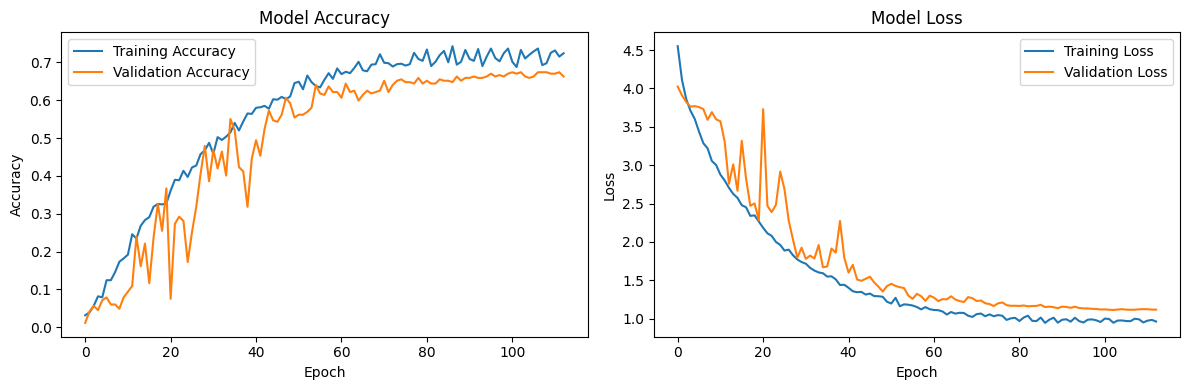

In [52]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



In [35]:
# Save the model
model_save_path = 'sign_language_GRU_model_76.78%'
model.save(model_save_path)
print(f"\nModel saved to: {model_save_path}")

INFO:tensorflow:Assets written to: sign_language_GRU_model_76.78%\assets


INFO:tensorflow:Assets written to: sign_language_GRU_model_76.78%\assets



Model saved to: sign_language_GRU_model_76.78%


In [42]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
y_hat = model.predict(X_test)

9/9 [==============================] - 0s 15ms/step


In [43]:
y_true = np.argmax(y_test, axis=1).tolist()
y_hat = np.argmax(y_hat, axis=1).tolist()

In [45]:
multilabel_confusion_matrix(y_true, y_hat)

array([[[265,   1],
        [  1,   0]],

       [[260,   2],
        [  2,   3]],

       [[258,   1],
        [  4,   4]],

       [[262,   0],
        [  0,   5]],

       [[262,   1],
        [  3,   1]],

       [[260,   4],
        [  0,   3]],

       [[266,   0],
        [  0,   1]],

       [[262,   1],
        [  0,   4]],

       [[263,   0],
        [  0,   4]],

       [[262,   0],
        [  1,   4]],

       [[259,   0],
        [  4,   4]],

       [[255,   7],
        [  2,   3]],

       [[261,   0],
        [  2,   4]],

       [[258,   3],
        [  1,   5]],

       [[265,   0],
        [  0,   2]],

       [[256,   1],
        [  2,   8]],

       [[263,   1],
        [  0,   3]],

       [[263,   1],
        [  1,   2]],

       [[261,   1],
        [  3,   2]],

       [[264,   0],
        [  1,   2]],

       [[262,   2],
        [  1,   2]],

       [[263,   1],
        [  0,   3]],

       [[264,   1],
        [  0,   2]],

       [[262,   0],
        [  0, 

In [46]:
accuracy_score(y_true, y_hat)

0.7677902621722846

In [ ]:
test = X_test[:10]
y_test[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [61]:
one_hot_label = y_test[:10]
# print(one_hot_label)
number_label = np.argmax(one_hot_label[0])
number_label

56

In [68]:
# 1. Get your single test sample (shape: (30, 258))
test_sample = X_test[200]

# 2. Get the true label number
one_hot_label = y_test[200]
true_label = np.argmax(one_hot_label)

# 3. CRITICAL: Add the batch dimension (shape becomes (1, 30, 258))
model_input = np.expand_dims(test_sample, axis=0)

# 4. Now, make the prediction
predictions = model.predict(model_input)

# 5. Get the predicted label number
# predictions[0] will be the array of 59 probabilities
predicted_label = np.argmax(predictions[0])


# --- Now you can check if they match ---
print(f"True Label: {true_label}")
print(f"Predicted Label: {predicted_label}")

if predicted_label == true_label:
    print("\nSUCCESS! The model gave the right prediction.")
else:
    print("\nFAILURE! The model gave the wrong prediction.")

# Optional: See the confidence
confidence = predictions[0][predicted_label]
print(f"Confidence: {confidence * 100:.2f}%")

1/1 [==============================] - 0s 45ms/step
True Label: 11
Predicted Label: 11

SUCCESS! The model gave the right prediction.
Confidence: 66.82%
